In [1]:
# Import required libraries
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib.patches import Polygon
import pandas as pd
from IPython.core.display import HTML
import numpy as np
import matplotlib.dates as mdates
%matplotlib inline
import scipy
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
from matplotlib.ticker import MultipleLocator
plt.rcParams["font.sans-serif"] = "Arial"

In [2]:
#Read in raw data sheet as pandas dataframe
df = pd.read_csv('../Data/NeutronProbeData.csv')

df['day'] = pd.to_datetime(df['day'])
df['day']=df['day'].dt.date
#Display snippet of the data

df.head()


,day,Hole ID,Depth (m),Neutron Count (MD),Theta
0,2016-05-02,500,0.09,1755,0.096460
1,2016-05-02,500,0.40,5118,0.338596
2,2016-05-02,500,0.70,5577,0.371644
3,2016-05-02,500,1.01,5321,0.353212
4,2016-05-02,500,1.31,5256,0.348532


In [3]:
#Read in datasheet of soil depths observed while drilling
soil_depths = pd.read_csv('../Data/Sagehorn Well Logs - Soil depths.csv')
borehole_to_soil_depth = dict(zip(soil_depths['Borehole'], soil_depths['Soil depth (cm)']/100))
soil_depths.head()

,Borehole,Soil depth (cm),Notes
0,MN-1,35.0,Based on notes from hand augering
1,MS-4,70.0,Based on notes from hand augering
2,500,55.0,Based on SPT recovered samples from W500 w/ ro...
3,501,55.0,Based on SPT recovered samples from W500 w/ ro...
4,502,55.0,Based on SPT recovered samples from W500 w/ ro...


In [4]:
df['Soil depth'] = df['Hole ID'].map(borehole_to_soil_depth)
df.head()

,day,Hole ID,Depth (m),Neutron Count (MD),Theta,Soil depth
0,2016-05-02,500,0.09,1755,0.096460,0.55
1,2016-05-02,500,0.40,5118,0.338596,0.55
2,2016-05-02,500,0.70,5577,0.371644,0.55
3,2016-05-02,500,1.01,5321,0.353212,0.55
4,2016-05-02,500,1.31,5256,0.348532,0.55


In [5]:
# Remove soil measurements
df_with_soils = df.copy()
df = df[df['Depth (m)']>=df['Soil depth']]

In [6]:
# CALCULATE ROCK MOISTURE LOSSES OVER DRY SEASON
# STORE IN DICTIONARIES
rm_dict = {}
rm_se_dict = {}
rm_june_dict = {}
rm_july_dict = {}

holes = sorted(set(df['Hole ID']))
for hole in holes:
    well = df[df['Hole ID']==hole]
    depths = sorted(set(well['Depth (m)']))

    mmRockMoisture=0.0
    mmJune=0.0
    mmJuly=0.0
    mmRockMoisture_sd_sum = 0.0

    for i, depth in enumerate(depths):
        i=i+1 #counter for estimating standard error of mean
        thisDepth = well[well['Depth (m)']==(depth)]
        dTheta =thisDepth['Theta'].iloc[0]-thisDepth['Theta'].iloc[-1]
        dTheta_sd = 0.0031 #median standard deviation of repeat counts; instrument measurement uncertainty in volumetric water content
        dMM = dTheta * 0.3048 * 1000
        #now just determine June 24 onward
        thisDepth = thisDepth[pd.to_datetime(thisDepth.day)>pd.to_datetime('2016-06-24')]
        dTheta_june = thisDepth['Theta'].iloc[0]-thisDepth['Theta'].iloc[-1]
        dMM_june = dTheta_june * 0.3048 * 1000

        #now just determine July 25 onward
        thisDepth = thisDepth[pd.to_datetime(thisDepth.day)>pd.to_datetime('2016-07-23')]

        if len(thisDepth)>0:
            dTheta_july = thisDepth['Theta'].iloc[0]-thisDepth['Theta'].iloc[-1]
            dMM_july = dTheta_july * 0.3048 * 1000


        #now sum 
        dMM_sd = (dTheta_sd * 0.3048 * 1000)
        mmRockMoisture = mmRockMoisture+dMM
        mmRockMoisture_sd_sum = mmRockMoisture_sd_sum + dMM_sd
        mmJune = mmJune+dMM_june
        mmJuly = mmJuly+dMM_july
    rm_dict.update({hole : int(mmRockMoisture)})
    rm_se_dict.update({hole : (mmRockMoisture_sd_sum / (i**0.5))})
    rm_june_dict.update({hole : int(mmJune)})
    rm_july_dict.update({hole : int(mmJuly)})




In [7]:
# holes = sorted(set(df['Hole ID']))
holes=['MN-1',
 'MS-4','505','503','500',
 '501',
 '502','506',
 '507',
 '508']

In [8]:
veg_dict={'MN-1':'oaks',
          'MS-4':'oaks',
          '505':'mixed trees',
          '503':'mixed trees',
          '500':'herbaceous',
          '501':'herbaceous',
          '502':'herbaceous',
          '506':'herbaceous',
          '507':'herbaceous',
          '508':'herbaceous'}
color_dict={'MN-1':'darkgreen',
          'MS-4':'darkgreen',
          '505':'forestgreen',
          '503':'forestgreen',
          '500':'darkgoldenrod',
          '501':'darkgoldenrod',
          '502':'darkgoldenrod',
          '506':'darkgoldenrod',
          '507':'darkgoldenrod',
          '508':'darkgoldenrod'}

In [9]:
litho_dict={'MN-1':'mélange',
            'MS-4':'mélange',
            '505':'sandstone',
            '503':'sandstone',
            '500':'mélange',
            '501':'mélange',
            '502':'mélange',
            '506':'mélange',
            '507':'mélange',
            '508':'mélange'}

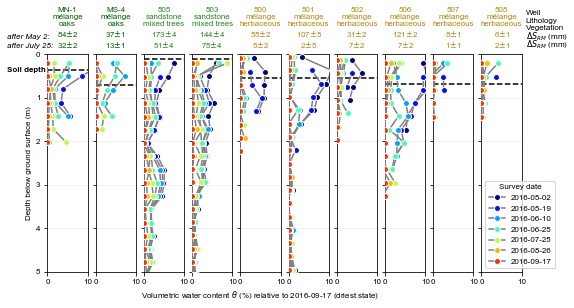

In [10]:
# Plot data
# CHANGE IN VOLUMETRIC WATER CONTENT
import matplotlib
matplotlib.rcParams.update({'font.size': 8})

fig, axarr=plt.subplots(1,len(holes),figsize=(8.5,4), sharex=True,sharey=True)

days = sorted(np.unique(df_with_soils['day']), reverse=False)
cNorm  = colors.Normalize(vmin=0, vmax=len(days))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=plt.get_cmap('jet') ) #_r reverses cmap

for i,hole in enumerate(litho_dict.keys()):
    well = df_with_soils[df_with_soils['Hole ID']==hole]
    driest = well[well['day']==days[-1]].sort_values('Depth (m)')
    for day in days:
        thisday = well[well['day']==day]
        thisday = thisday.sort_values('Depth (m)')
        plotData = pd.merge(driest,thisday,on='Depth (m)',how='outer',suffixes=('_driest','_thisday'))
        axarr[i].plot((plotData['Theta_thisday']-plotData['Theta_driest'])*100,
                      plotData['Depth (m)'],clip_on=True,
                      label=str(day),color='grey', linestyle='solid', marker='o',
                      markerfacecolor=colors.rgb2hex(scalarMap.to_rgba(days.index(day))),
                      markeredgecolor='white', markersize=6,zorder=10)


    axarr[i].axhline(borehole_to_soil_depth[hole],ls='--',c='k')
    axarr[i].set_title(hole + '\n' +
                       litho_dict[hole] +'\n'+
                       veg_dict[hole]+'\n'+
                       str(rm_dict[hole]) + r'$\pm$' + str(int(rm_se_dict[hole]))+'\n' +
                       str(rm_july_dict[hole]) + r'$\pm$' + str(int(rm_se_dict[hole])),
                       fontsize=8,
                       color=color_dict[hole])
    
    axarr[i].grid(alpha=.2)
axarr[i].set_ylim(5,0)
axarr[i].set_xlim(0,10)

axarr[-1].legend(title='Survey date')
    
axarr[0].set_ylabel('Depth below ground surface (m)')
axarr[4].set_xlabel(r'Volumetric water content $\theta$ (%) relative to 2016-09-17 (driest state)')

axarr[-1].text(11,-.90,'Well',fontsize=8)
axarr[-1].text(11,-0.725,'Lithology',fontsize=8)
axarr[-1].text(11,-0.55,'Vegetation',fontsize=8)
axarr[-1].text(11,-0.35,r'$\Delta$$S_{RM}$ (mm)',fontsize=8)
axarr[-1].text(11,-0.15,r'$\Delta$$S_{RM}$ (mm)',fontsize=8)

axarr[0].text(-10,-0.35,'after May 2:',fontsize=8,style='italic')
axarr[0].text(-10,-0.15,'after July 25:',fontsize=8,style='italic')
axarr[0].text(-10,0.4,'Soil depth',fontsize=8,fontweight='bold')

coords = [[-5,-1],[20,-1],
                  [20,6],
        [-5,6]]
plt.Polygon(coords,ec='black',fc='red',zorder=100, clip_on=False)

# fig.tight_layout()
plt.savefig('../Figs/Neutron_Probe_Depth_vs_Volumetric_Water_Content_Change.pdf',
           bbox_inches='tight')